In [24]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(555)
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (15, 7)
mpl.rcParams['axes.grid'] = True
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

def read_data(timeframe):
    train = pd.read_csv("data/"+timeframe+"_train.csv")
    valid = pd.read_csv("data/"+timeframe+"_valid.csv")
    test = pd.read_csv("data/"+timeframe+"_test.csv")
    
    return train, valid, test

def get_windowed_data(tempdf, wsize):
    f = []
    l = []
    for i in range(wsize, tempdf.shape[0]):
        window = tempdf.iloc[i-wsize:i, :]
        features = window.iloc[:, :-1].values
        labels = window.iloc[-1, -1]
        f.append(features)
        l.append(labels)

    f = np.array(f)
    l = np.array(l).reshape(len(l), 1)
    return f, l

def get_train_valid_test_x_y_data(train, valid, test, timeframe):
    if timeframe == "day":
        wsize = 2
    if timeframe == "hour":
        wsize = 12
    if timeframe == "minute":
        wsize = 30
    trainx, trainy = get_windowed_data(train, wsize)
    print("TRAIN: ", "x: ", trainx.shape, " y: ", trainy.shape)
    validx, validy = get_windowed_data(valid, wsize)
    print("VALID: ", "x: ", validx.shape, " y: ", validy.shape)
    testx, testy = get_windowed_data(test, wsize)
    print("TEST: ", "x: ", testx.shape, " y: ", testy.shape)
    
    return trainx, trainy, validx, validy, testx, testy

def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

def analyze_predictions(model, testx, testy, timeframe):
    preds = pd.DataFrame({"Prediction":model.predict(testx).squeeze(), "True": testy.squeeze()})
    print("MAE: ", mae(preds["True"], preds.Prediction))
    print("RMSE: ", mse(preds["True"], preds.Prediction, squared = False))
    ax = preds.plot(figsize = (15, 7))
    ax.set(xlabel='Index', ylabel='Change')
    plt.savefig('images/'+timeframe+'_lstm_results.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
    plt.savefig('images/'+timeframe+'_lstm_results.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
    plt.show()

def xy(df):
    return df.iloc[:, :-1], df.iloc[:, -1]

def plot_errors(modelfit, timeframe):
    errors = pd.DataFrame({'Training loss':modelfit.history['loss'], 'Validation loss': modelfit.history['val_loss']})
    ax = errors.plot()
    plt.title('LSTM')
    plt.xlabel('Epochs numbers')
    plt.ylabel('MSE numbers')
    plt.legend()
    plt.savefig('images/'+timeframe+'_lstm_errors.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
    plt.savefig('images/'+timeframe+'_lstm_errors.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
    plt.show()
    
zero_base = True
lstm_neurons = 50
epochs = 200
batch_size = 64
loss = 'mse'
dropout = 0.24
optimizer = 'adam'

# Day

In [18]:
daytrain, dayvalid, daytest = read_data("day")
daytrainx, daytrainy,dayvalidx, dayvalidy,daytestx, daytesty = get_train_valid_test_x_y_data(daytrain, dayvalid, daytest, "day")

TRAIN:  x:  (25, 2, 25)  y:  (25, 1)
VALID:  x:  (5, 2, 25)  y:  (5, 1)
TEST:  x:  (13, 2, 25)  y:  (13, 1)


In [19]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = build_lstm_model(
    daytrainx, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

modelfit = model.fit(
    daytrainx, daytrainy, validation_data=(dayvalidx, dayvalidy), epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True, callbacks = [es])

Epoch 1/200


2022-05-23 01:03:10.403689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:03:10.511668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:03:10.551378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 - 1s - loss: 2.0020 - val_loss: 1.6989 - 663ms/epoch - 663ms/step
Epoch 2/200
1/1 - 0s - loss: 1.9085 - val_loss: 1.6011 - 21ms/epoch - 21ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8332 - val_loss: 1.5354 - 20ms/epoch - 20ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7573 - val_loss: 1.4872 - 20ms/epoch - 20ms/step
Epoch 5/200
1/1 - 0s - loss: 1.7012 - val_loss: 1.4483 - 19ms/epoch - 19ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6265 - val_loss: 1.4140 - 23ms/epoch - 23ms/step
Epoch 7/200
1/1 - 0s - loss: 1.5722 - val_loss: 1.3810 - 19ms/epoch - 19ms/step


2022-05-23 01:03:10.687998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:03:10.728680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 8/200
1/1 - 0s - loss: 1.5114 - val_loss: 1.3490 - 19ms/epoch - 19ms/step
Epoch 9/200
1/1 - 0s - loss: 1.4615 - val_loss: 1.3183 - 23ms/epoch - 23ms/step
Epoch 10/200
1/1 - 0s - loss: 1.4117 - val_loss: 1.2868 - 21ms/epoch - 21ms/step
Epoch 11/200
1/1 - 0s - loss: 1.3673 - val_loss: 1.2510 - 20ms/epoch - 20ms/step
Epoch 12/200
1/1 - 0s - loss: 1.3202 - val_loss: 1.2073 - 23ms/epoch - 23ms/step
Epoch 13/200
1/1 - 0s - loss: 1.2707 - val_loss: 1.1613 - 20ms/epoch - 20ms/step
Epoch 14/200
1/1 - 0s - loss: 1.2129 - val_loss: 1.1212 - 19ms/epoch - 19ms/step
Epoch 15/200
1/1 - 0s - loss: 1.1634 - val_loss: 1.0819 - 19ms/epoch - 19ms/step
Epoch 16/200
1/1 - 0s - loss: 1.1139 - val_loss: 1.0324 - 21ms/epoch - 21ms/step
Epoch 17/200
1/1 - 0s - loss: 1.0565 - val_loss: 0.9530 - 20ms/epoch - 20ms/step
Epoch 18/200
1/1 - 0s - loss: 0.9906 - val_loss: 0.8737 - 20ms/epoch - 20ms/step
Epoch 19/200
1/1 - 0s - loss: 0.9362 - val_loss: 0.8167 - 23ms/epoch - 23ms/step
Epoch 20/200
1/1 - 0s - loss: 

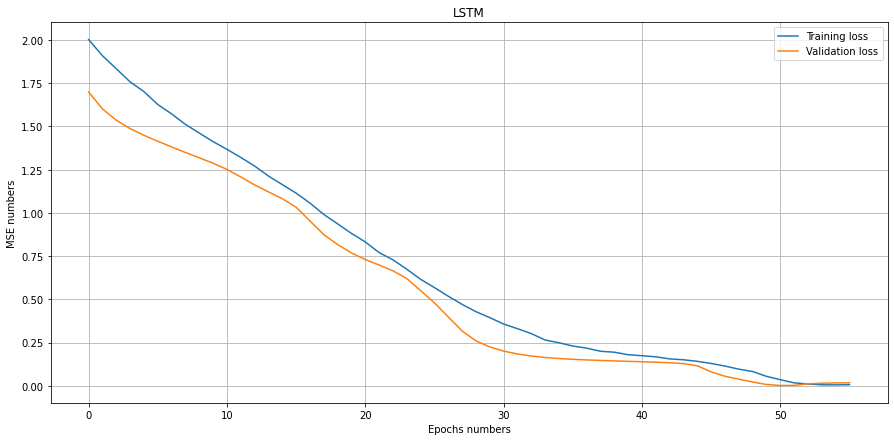

In [25]:
plot_errors(modelfit, "day")

2022-05-23 01:03:56.858237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:03:56.892102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MAE:  0.06578808920092549
RMSE:  0.07699345318667597


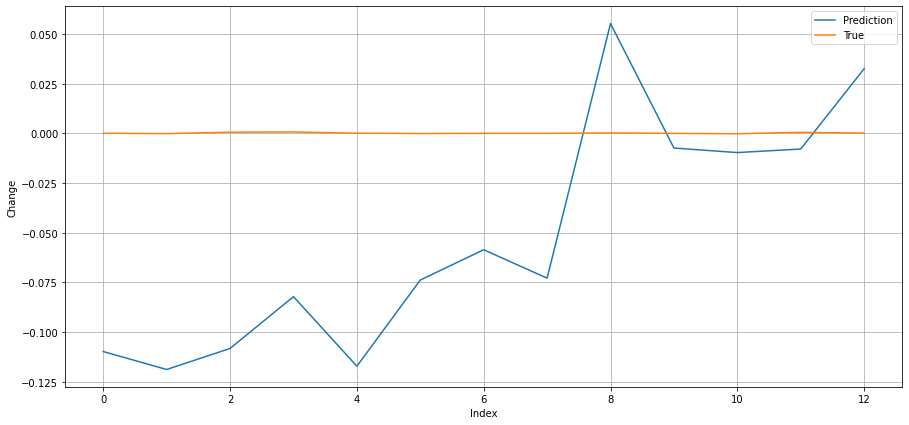

In [27]:
analyze_predictions(model, daytestx, daytesty, "day")

# Hour

In [28]:
hourtrain, hourvalid, hourtest = read_data("hour")
hourtrainx, hourtrainy,hourvalidx, hourvalidy,hourtestx, hourtesty = get_train_valid_test_x_y_data(hourtrain, hourvalid, hourtest, "hour")

TRAIN:  x:  (676, 12, 25)  y:  (676, 1)
VALID:  x:  (161, 12, 25)  y:  (161, 1)
TEST:  x:  (358, 12, 25)  y:  (358, 1)


In [29]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = build_lstm_model(
    hourtrainx, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

modelfit = model.fit(
    hourtrainx, hourtrainy, validation_data=(hourvalidx, hourvalidy), epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True, callbacks = [es])

Epoch 1/200


2022-05-23 01:04:06.538897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:04:06.664812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:04:06.712978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 - 1s - loss: 7.6854 - val_loss: 4.9113 - 1s/epoch - 98ms/step


2022-05-23 01:04:07.008506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:04:07.049396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/200
11/11 - 0s - loss: 3.9138 - val_loss: 2.7604 - 168ms/epoch - 15ms/step
Epoch 3/200
11/11 - 0s - loss: 2.0877 - val_loss: 1.5692 - 145ms/epoch - 13ms/step
Epoch 4/200
11/11 - 0s - loss: 1.1038 - val_loss: 0.8848 - 142ms/epoch - 13ms/step
Epoch 5/200
11/11 - 0s - loss: 0.5534 - val_loss: 0.4704 - 139ms/epoch - 13ms/step
Epoch 6/200
11/11 - 0s - loss: 0.2640 - val_loss: 0.2336 - 142ms/epoch - 13ms/step
Epoch 7/200
11/11 - 0s - loss: 0.1609 - val_loss: 0.1366 - 149ms/epoch - 14ms/step
Epoch 8/200
11/11 - 0s - loss: 0.1346 - val_loss: 0.1032 - 121ms/epoch - 11ms/step
Epoch 9/200
11/11 - 0s - loss: 0.1192 - val_loss: 0.0862 - 136ms/epoch - 12ms/step
Epoch 10/200
11/11 - 0s - loss: 0.1030 - val_loss: 0.0744 - 155ms/epoch - 14ms/step
Epoch 11/200
11/11 - 0s - loss: 0.0890 - val_loss: 0.0646 - 150ms/epoch - 14ms/step
Epoch 12/200
11/11 - 0s - loss: 0.0761 - val_loss: 0.0560 - 154ms/epoch - 14ms/step
Epoch 13/200
11/11 - 0s - loss: 0.0663 - val_loss: 0.0496 - 145ms/epoch - 13ms/step


Epoch 100/200
11/11 - 0s - loss: 0.0021 - val_loss: 6.8875e-04 - 131ms/epoch - 12ms/step
Epoch 101/200
11/11 - 0s - loss: 0.0019 - val_loss: 6.7384e-04 - 139ms/epoch - 13ms/step
Epoch 102/200
11/11 - 0s - loss: 0.0020 - val_loss: 6.4747e-04 - 143ms/epoch - 13ms/step
Epoch 103/200
11/11 - 0s - loss: 0.0019 - val_loss: 6.2001e-04 - 136ms/epoch - 12ms/step
Epoch 104/200
11/11 - 0s - loss: 0.0018 - val_loss: 6.1002e-04 - 142ms/epoch - 13ms/step
Epoch 105/200
11/11 - 0s - loss: 0.0017 - val_loss: 6.0139e-04 - 140ms/epoch - 13ms/step
Epoch 106/200
11/11 - 0s - loss: 0.0017 - val_loss: 5.7933e-04 - 144ms/epoch - 13ms/step
Epoch 107/200
11/11 - 0s - loss: 0.0016 - val_loss: 5.6242e-04 - 150ms/epoch - 14ms/step
Epoch 108/200
11/11 - 0s - loss: 0.0015 - val_loss: 5.4741e-04 - 142ms/epoch - 13ms/step
Epoch 109/200
11/11 - 0s - loss: 0.0017 - val_loss: 5.3936e-04 - 138ms/epoch - 13ms/step
Epoch 110/200
11/11 - 0s - loss: 0.0017 - val_loss: 5.3288e-04 - 148ms/epoch - 13ms/step
Epoch 111/200
11/11 -

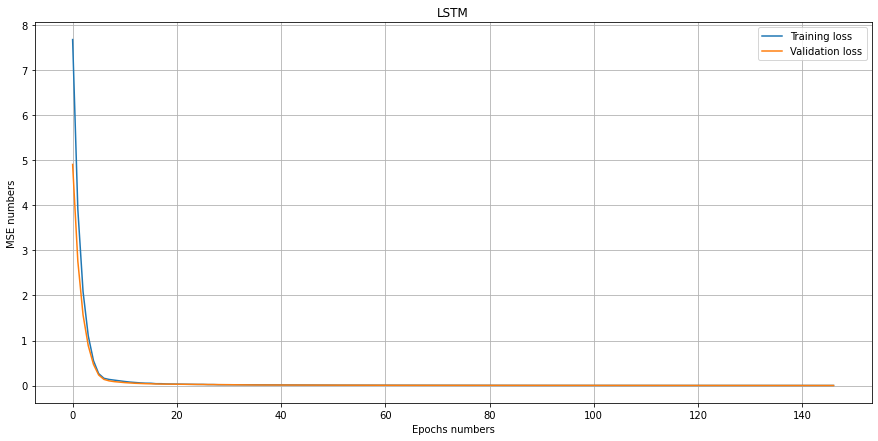

In [30]:
plot_errors(modelfit, "hour")

2022-05-23 01:04:37.338933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:04:37.373522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MAE:  0.011020128984524593
RMSE:  0.014451153627748113


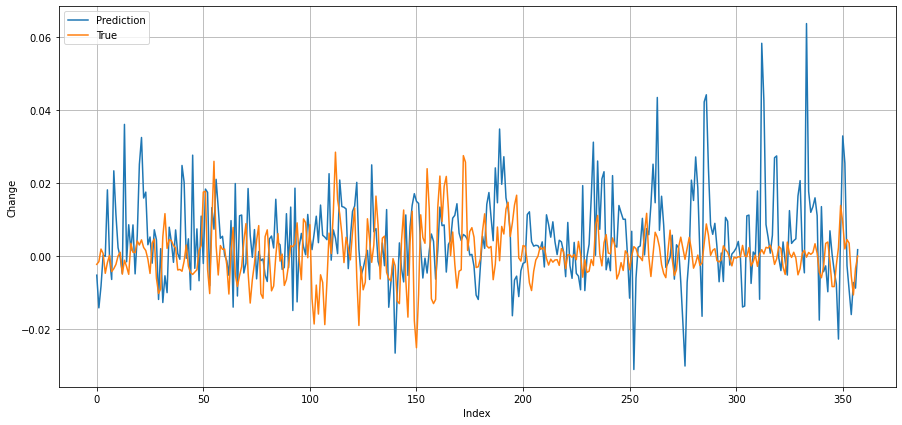

In [31]:
analyze_predictions(model, hourtestx, hourtesty, "hour")

# Minute

In [32]:
mtrain, mvalid, mtest = read_data("minute")
mtrainx, mtrainy,mvalidx, mvalidy,mtestx, mtesty = get_train_valid_test_x_y_data(mtrain, mvalid, mtest, "minute")

TRAIN:  x:  (5107, 30, 25)  y:  (5107, 1)
VALID:  x:  (1255, 30, 25)  y:  (1255, 1)
TEST:  x:  (2723, 30, 25)  y:  (2723, 1)


In [33]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = build_lstm_model(
    mtrainx, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

modelfit = model.fit(
    mtrainx, mtrainy, validation_data=(mvalidx, mvalidy), epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True, callbacks = [es])

Epoch 1/200


2022-05-23 01:05:10.053593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:05:10.164751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:05:10.229753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:05:11.660279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:05:11.700599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


80/80 - 2s - loss: 0.3853 - val_loss: 0.0444 - 2s/epoch - 27ms/step
Epoch 2/200
80/80 - 1s - loss: 0.0308 - val_loss: 0.0269 - 1s/epoch - 15ms/step
Epoch 3/200
80/80 - 1s - loss: 0.0198 - val_loss: 0.0159 - 1s/epoch - 16ms/step
Epoch 4/200
80/80 - 1s - loss: 0.0123 - val_loss: 0.0089 - 1s/epoch - 15ms/step
Epoch 5/200
80/80 - 1s - loss: 0.0078 - val_loss: 0.0053 - 1s/epoch - 16ms/step
Epoch 6/200
80/80 - 1s - loss: 0.0050 - val_loss: 0.0034 - 1s/epoch - 16ms/step
Epoch 7/200
80/80 - 1s - loss: 0.0035 - val_loss: 0.0023 - 1s/epoch - 15ms/step
Epoch 8/200
80/80 - 1s - loss: 0.0023 - val_loss: 0.0013 - 1s/epoch - 16ms/step
Epoch 9/200
80/80 - 1s - loss: 0.0015 - val_loss: 7.5442e-04 - 1s/epoch - 16ms/step
Epoch 10/200
80/80 - 1s - loss: 9.5069e-04 - val_loss: 4.5942e-04 - 1s/epoch - 16ms/step
Epoch 11/200
80/80 - 1s - loss: 6.2748e-04 - val_loss: 2.5898e-04 - 1s/epoch - 19ms/step
Epoch 12/200
80/80 - 1s - loss: 4.2357e-04 - val_loss: 1.4429e-04 - 1s/epoch - 17ms/step
Epoch 13/200
80/80 - 

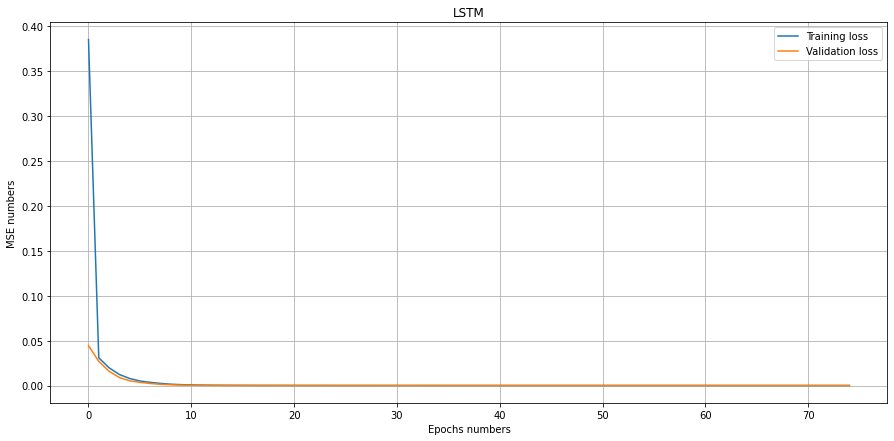

In [34]:
plot_errors(modelfit, "minute")

2022-05-23 01:06:47.969152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:06:48.007751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MAE:  0.00196237072829906
RMSE:  0.002291462747636154


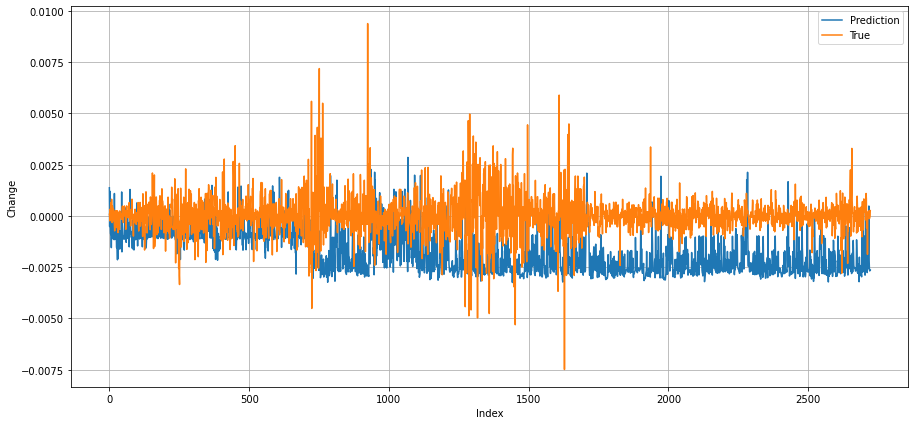

In [35]:
analyze_predictions(model, mtestx, mtesty, "minute")